## Import required packages and setup
Before we begin our analysis, we import some required packages and specify our desired figure settings.

In [9]:
#import packages (required for analysis)
%pylab inline
import numpy as np
import pandas as pd
from scipy import stats, optimize
import matplotlib.pyplot as plt
import seaborn as sns
import os, csv
import statsmodels.api as sm
from sqlalchemy import create_engine, MetaData, Table
import json


# setup some of the figure aesthetics to make it look prettier


Populating the interactive namespace from numpy and matplotlib


Next, we set some useful parameters to tell pandas where our data and required files are located.

In [15]:
#params (change these for every experiment)
DATA_PATH = '/Users/kathrynschuler/Documents/current/research/raw-data/'
exp_id = '0162'
exp_title = 'empiricalYang-36Noun-HFrule-mturk'


In [18]:
## The db_url has to look like this. you get the particiant.db from the server location of the experiment by
## using the command :
## scp -r -P 8008 kschuler@104.131.28.137:path/to/exp/file.db $HOME/Path/to/raw-data
db_url = "sqlite:///"+DATA_PATH+exp_id+"-"+exp_title+"-data/participants.db"
## table name set in config.txt of experiment file
table_name = '0162'
## data_column_name set automatically by psiturk
data_column_name = 'datastring'

print db_url

sqlite:////Users/kathrynschuler/Documents/current/research/raw-data/0162-empiricalYang-36Noun-HFrule-mturk-data/participants.db


In [19]:
# boilerplace sqlalchemy setup
engine = create_engine(db_url)
metadata = MetaData()
metadata.bind = engine
table = Table(table_name, metadata, autoload=True)

In [20]:
# make a query and loop through
s = table.select()
rows = s.execute()

data = []
#status codes of subjects who completed experiment
statuses = [3, 4, 5, 7]
# if you have workers you wish to exclude, add them here
exclude = ['A35YZM09QR7IZG:31T4R4OBOSH1FCCIYPT45L0HETLC7K']
for row in rows:
    # only use subjects who completed experiment and aren't excluded
    if row['status'] in statuses and row['uniqueid'] not in exclude:
        data.append(row[data_column_name])

In [21]:
# Now we have all participant datastrings in a list.
# Let's make it a bit easier to work with:

# parse each participant's datastring as json object
# and take the 'data' sub-object
data = [json.loads(part)['data'] for part in data]

# insert uniqueid field into trialdata in case it wasn't added
# in experiment:
for part in data:
    for record in part:
        record['trialdata']['uniqueid'] = record['uniqueid']

# flatten nested list so we just have a list of the trialdata recorded
# each time psiturk.recordTrialData(trialdata) was called.
data = [record['trialdata'] for part in data for record in part]

# Put all subjects' trial data into a dataframe object from the
# 'pandas' python library: one option among many for analysis
data_frame = pd.DataFrame(data)



In [22]:
# get all of the unique subject IDs, then check subject tracking to make sure they match
print data_frame.head()

               action case condition correct counterbalance  det detnum error  \
0               Begin  NaN       NaN     NaN            NaN  NaN    NaN   NaN   
1            NextPage  NaN       NaN     NaN            NaN  NaN    NaN   NaN   
2            NextPage  NaN       NaN     NaN            NaN  NaN    NaN   NaN   
3            NextPage  NaN       NaN     NaN            NaN  NaN    NaN   NaN   
4  FinishInstructions  NaN       NaN     NaN            NaN  NaN    NaN   NaN   

   indexOf   n    ...                                             templates  \
0      NaN NaN    ...     [instructions/instruct-1.html, instructions/in...   
1        0 NaN    ...                                                   NaN   
2        1 NaN    ...                                                   NaN   
3        2 NaN    ...                                                   NaN   
4        3 NaN    ...                                                   NaN   

  test_number type type-full          

In [23]:
#load subject tracking sheet
#tracking_sheet = DATA_PATH+'subject-tracking/'+exp_id+'-'+exp_title+'-track.csv'
#subj_track = pd.read_csv(tracking_sheet)

#merge subject tracking with data
#data_frame = pd.merge(data_frame, subj_track, on='uniqueid')

#summary_data = data_frame.groupby(['condition', 'counterbalance', 'phase','uniqueid' ], as_index=False)['n'].count()
#g = sns.FacetGrid(data_frame, row="whichLang", col="whichCond", margin_titles=True)
#g.map(sns.regplot, "phase", "uniqueid", color=".3", fit_reg=False, x_jitter=.1);
#summary_data.pivot(columns="phase", value="n")

In [24]:
# isolate the instruction sections
data_instructions = data_frame[data_frame.phase == 'INSTRUCTIONS']
data_instructions = data_instructions[['action', 'phase', 'template', 'uniqueid', 'viewTime']]

# isolate the exposure phase
data_production = data_frame[data_frame.phase == 'production']
data_production = data_production[['phase', 'uniqueid', 'condition', 'counterbalance', 'n', 'verb', 'noun', 'det', 'test_number', 'type','user_input']]
data_production = data_production.dropna()

# isolate the rating phase
data_rating = data_frame[data_frame.phase == 'rating']
#data_rating = data_rating.rename(columns={'cat': 'type-full'})
data_rating = data_rating[['phase', 'uniqueid', 'condition', 'counterbalance','n', 'verb', 'noun', 'det', 'number', 'type', 'error','user_input']]
data_rating = data_rating.dropna()

# merge these two together
prod_and_rate = data_frame.query('phase in ["production", "rating"]' )
prod_and_rate = prod_and_rate[['condition', 'counterbalance', 'det', 'n', 'noun', 'phase', 'number', 'type', 'uniqueid', 'verb', 'user_input']]
prod_and_rate = prod_and_rate.dropna()


In [25]:
# summary_data = prod_and_rate.groupby(['condition', 'counterbalance', 'phase','uniqueid'], as_index = False)['uniqueid'].count()
# #g = sns.FacetGrid(summary_data, row="condition", col="counterbalance", margin_titles=True)
# #g.map(sns.regplot, "phase", "uniqueid", color=".3", fit_reg=False, x_jitter=.1);
# #summary_data.pivot(columns="phase", value="n")
# print summary_data
print data_rating

       phase                                       uniqueid condition  \
204   rating  A27BSYPO6JCB4Q:3Z3ZLGNNSIVN8ULE1VR9C9DLTZQ3Q9         1   
205   rating  A27BSYPO6JCB4Q:3Z3ZLGNNSIVN8ULE1VR9C9DLTZQ3Q9         1   
206   rating  A27BSYPO6JCB4Q:3Z3ZLGNNSIVN8ULE1VR9C9DLTZQ3Q9         1   
207   rating  A27BSYPO6JCB4Q:3Z3ZLGNNSIVN8ULE1VR9C9DLTZQ3Q9         1   
208   rating  A27BSYPO6JCB4Q:3Z3ZLGNNSIVN8ULE1VR9C9DLTZQ3Q9         1   
209   rating  A27BSYPO6JCB4Q:3Z3ZLGNNSIVN8ULE1VR9C9DLTZQ3Q9         1   
210   rating  A27BSYPO6JCB4Q:3Z3ZLGNNSIVN8ULE1VR9C9DLTZQ3Q9         1   
211   rating  A27BSYPO6JCB4Q:3Z3ZLGNNSIVN8ULE1VR9C9DLTZQ3Q9         1   
212   rating  A27BSYPO6JCB4Q:3Z3ZLGNNSIVN8ULE1VR9C9DLTZQ3Q9         1   
213   rating  A27BSYPO6JCB4Q:3Z3ZLGNNSIVN8ULE1VR9C9DLTZQ3Q9         1   
214   rating  A27BSYPO6JCB4Q:3Z3ZLGNNSIVN8ULE1VR9C9DLTZQ3Q9         1   
215   rating  A27BSYPO6JCB4Q:3Z3ZLGNNSIVN8ULE1VR9C9DLTZQ3Q9         1   
216   rating  A27BSYPO6JCB4Q:3Z3ZLGNNSIVN8ULE1VR9C9

In [26]:
#make sure every subject does all 18 of the ratings.
data_rating.uniqueid.value_counts()

A2EI075XZT9Y2S:34YB12FSQYPXHRZA4HRCEUIPN3XGM6    36
AETIZKQNUSBLB:3U84XHCDICEH4I59O5F5D7HVC26Z4J     36
A1MYLQQL8BBOYT:3XLBSAQ9Z4DEN5NSQ3DCGJ1534WZ73    36
A2RBF3IIJP15IH:3WJ1OXY92AHHMBK3OGPJDQ6R53V8AY    36
A36SM7QM8OK3H6:3WI0P0II61TL2N2B7ZMLU892GYGRDV    36
A27BSYPO6JCB4Q:3Z3ZLGNNSIVN8ULE1VR9C9DLTZQ3Q9    36
A1GXFMAC759VRM:3MX2NQ3YC9VAV69U1SAULE7Y4Y2X5O    36
A2YJQUHFIXNOY0:3Z2R0DQ0JHF9Q9ZQO4I4ZIJF4I1E2W    36
A2AMI7BVALOCJP:3VFJCI1K4Z0OE7C29PNT0TCZTQWRG5    35
A3N0QZ9ZKUCTCQ:326O153BMIZWTJX6LT2LV1AJ19RED6    35
A359ETX78LN74M:3JWH6J9I9SE78SCZ0WEYQYGSCGGBNL    35
A1945USNZHTROX:3Z7ISHFUH0WINJSB085IUJX0EO38Z0    34
AQL960O0LTRI8:33SA9F9TRXVV2PXX2O7BNPZ48PWWEW     34
ABO9F0JD9NN54:3RJSC4XJ10V2YG3JYGLNC0KNURI05X     33
dtype: int64

In [27]:
# get what noun and determiner they said
print data_production['user_input'].head()

splits = data_production['user_input'].str.split()
data_production['det_prod'] = splits.str[2]
data_production['noun-prod'] = splits.str[1]


data_rating.to_csv("/Users/kathrynschuler/Desktop/rating.csv")
data_production.to_csv("/Users/kathrynschuler/Desktop/production.csv")

190        gentif norg ka
191      gentif flugit ka
192      gentif daffin ka
193     gentif bleggin ka
194      gentif flugit ka
Name: user_input, dtype: object


In [16]:
# let's only care about Ka and Po for today
ka_po_production = data_production.query('det_prod in ["Ka", "ka", "Ka.", "ka."]')


# out of 16 trials, how many of them are ka/po for each subject - let's look at each subject
prod_subj = ka_po_production.groupby(['uniqueid'], sort=True)['det_prod'].sum()
prod_subj2 = data_production.groupby(['uniqueid'], sort=True)['det_prod'].apply(lambda x: "{%s}" % ', '.join(x))
print prod_subj2

TypeError: sequence item 3: expected string or Unicode, float found

In [13]:
%load_ext rmagic
%R -i prod_and_rate

    

/Users/kathrynschuler/anaconda/lib/python2.7/site-packages/IPython/extensions/rmagic.py:693: UserWarning: The rmagic extension in IPython is deprecated in favour of rpy2.ipython. If available, that will be loaded instead.
http://rpy.sourceforge.net/
  warnings.warn("The rmagic extension in IPython is deprecated in favour of "


In [14]:
%%R

summary(prod_and_rate)
head(prod_and_rate)

    condition counterbalance  det n   noun      phase number  type
192         1              0 null 1   norg production      1 novel
193         1              0 null 2   geed production      1 novel
194         1              0 null 3 flugit production      1 novel
195         1              0 null 4   geed production      1 novel
196         1              0 null 5    sep production      1 novel
197         1              0 null 6   norg production      1 novel
                   uniqueid   verb       user_input
192 debugKEHD9Q:debug45SXLV gentif   gentif norg ka
193 debugKEHD9Q:debug45SXLV gentif   gentif geed ka
194 debugKEHD9Q:debug45SXLV gentif gentif flugit ka
195 debugKEHD9Q:debug45SXLV gentif   gentif geed ka
196 debugKEHD9Q:debug45SXLV gentif  gentif sep null
197 debugKEHD9Q:debug45SXLV gentif gentif norg null


In [ ]:
%R install.packages('reshape')


In [ ]:
%%R
library(reshape)
cast(prod_and_rate, uniqueid ~ phase)

In [ ]:
%R -i data_rating

In [ ]:
%R -i data_production

In [ ]:
%%R

summary(data_rating)

In [ ]:
%%R
library(plyr)
library(ggplot2)
install.packages('doBy')

In [ ]:
%%R
levels(data_rating$condition) <- c("5 Rule | 4 Exception", "3 Rule | 6 Exception")
levels(data_production$condition) <- c("5 Rule | 4 Exception", "3 Rule | 6 Exception")
print(data_rating)
#rename(data_rating, c("type.full"="cat"))

In [ ]:
%%R
# With a data set with NA's, use na.rm=TRUE
## Summarizes data.
## Gives count, mean, standard deviation, standard error of the mean, and confidence 
## interval (default 95%).
##   data: a data frame.
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   na.rm: a boolean that indicates whether to ignore NA's
##   conf.interval: the percent range of the confidence interval (default is 95%)
summarySE <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE, conf.interval=.95) {
    library(doBy)

    # New version of length which can handle NA's: if na.rm==T, don't count them
    length2 <- function (x, na.rm=FALSE) {
        if (na.rm) sum(!is.na(x))
        else       length(x)
    }

    # Collapse the data
    formula <- as.formula(paste(measurevar, paste(groupvars, collapse=" + "), sep=" ~ "))
    datac <- summaryBy(formula, data=data, FUN=c(length2,mean,sd), na.rm=na.rm)

    # Rename columns
    names(datac)[ names(datac) == paste(measurevar, ".mean",    sep="") ] <- measurevar
    names(datac)[ names(datac) == paste(measurevar, ".sd",      sep="") ] <- "sd"
    names(datac)[ names(datac) == paste(measurevar, ".length2", sep="") ] <- "N"
    
    datac$se <- datac$sd / sqrt(datac$N)  # Calculate standard error of the mean
    
    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval: 
    # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
    ciMult <- qt(conf.interval/2 + .5, datac$N-1)
    datac$ci <- datac$se * ciMult
    
    return(datac)
}
det <- c('ka', 'po', 'lee','bae', 'tay', 'muy', 'woo')
detcat <- c('ka', 'non-ka', 'non-ka', 'non-ka', 'non-ka', 'non-ka', 'non-ka')

df <- data.frame(det, detcat)
dr <- merge(data_rating, df, by="det")

        
sum_data_rating = summarySE(dr, measurevar="user_input", groupvars=c("condition", "error","detcat"), na.rm=TRUE)
print(sum_data_rating)

In [ ]:
%%R
#print(sum_data_rating)
# Use dose as a factor rather than numeric
#dr <- sum_data_rating
sum_data_rating$condition <- factor(sum_data_rating$condition)

# Error bars represent standard error of the mean
g = ggplot(sum_data_rating, aes(x=error, y=user_input, fill=detcat)) + 
    geom_bar(position=position_dodge(), stat="identity", colour="black") +theme_classic()+ coord_cartesian(ylim=c(1.0,5.0)) + 
    facet_grid(~ condition) + scale_fill_manual(values=c("#111111", "#999999"))+ylab("Rating")+xlab("")

g = g + theme(axis.ticks=element_blank(), legend.title=element_blank(), legend.background = element_rect(colour="#111111",size=0.25), legend.position=c(0.1,0.925))

g +geom_errorbar(aes(ymin=user_input-se, ymax=user_input+se), width=.2, position=position_dodge(.9))

In [ ]:
%%R



In [ ]:
%%R
ggsave("0153-rating.png")

In [ ]:
%%R
head(data_production)
det_prod <- unique(data_production$det_prod)
print(det_prod)

In [29]:
%%R
users_answer_cat = c('ka', 'other', 'ka', 'other', 'other', 'other', 'other', 'other', 'other', 'non-ka', 'non-ka', 'non-ka',
                    'other', 'non-ka', 'other', 'other', 'other', 'other','other', 'non-ka', 'other', 'other', 'other', 'other',
                    'other', 'other', 'other', 'other', 'other')
ans_dict <- data.frame(det_prod, users_answer_cat)
dp <- merge(data_production, ans_dict, on=det_prod)

In [30]:
%%R
head(dp)

  det_prod      phase                                      uniqueid
1      bae production A1M03U3W99BGZ4:36W0OB37HWFBGUT43CZO7WQW334HZ7
2       bo production A1VNYP58BTF4HX:3TXWC2NHNZRL0CP7A8HOYMV5XBWS9N
3       bo production A1VNYP58BTF4HX:3TXWC2NHNZRL0CP7A8HOYMV5XBWS9N
4       bo production A1VNYP58BTF4HX:3TXWC2NHNZRL0CP7A8HOYMV5XBWS9N
5     bok. production A1M03U3W99BGZ4:36W0OB37HWFBGUT43CZO7WQW334HZ7
6     bok. production A1M03U3W99BGZ4:36W0OB37HWFBGUT43CZO7WQW334HZ7
             condition counterbalance n   verb   noun  det test_number  type
1 3 Rule | 6 Exception              0 2 gentif flugit null           5 novel
2 5 Rule | 4 Exception              0 8 gentif flugit null           3 novel
3 5 Rule | 4 Exception              0 7 gentif daffin null           5 novel
4 5 Rule | 4 Exception              0 6 gentif   norg null           5 novel
5 3 Rule | 6 Exception              0 5 gentif    sep null           5 novel
6 3 Rule | 6 Exception              0 6 gentif    sep null    

In [31]:
%%R
thistab <- table(dp$uniqueid, dp$users_answer_cat, dp$noun)
with(dp, table(uniqueid, users_answer_cat)) -> gen.adm.table
thisdp <- prop.table(gen.adm.table, 1)*100
#print(gen.adm.table)
mdata <- melt(thisdp, id="uniqueid")
#print(mdata)


cdata <- cast(mdata, uniqueid~users_answer_cat)
print(cdata)


                                        uniqueid         ka    non-ka
1  A13VIJ7G997ZCY:3R2UR8A0IAHW3GFC676TUK7M7PKXOE  33.333333 58.333333
2  A18LPAFMK1B06K:3NJM2BJS4W7QLIGIUBNL57R2GCSCP8 100.000000  0.000000
3  A1M03U3W99BGZ4:36W0OB37HWFBGUT43CZO7WQW334HZ7   8.333333  8.333333
4  A1P3Z24Y6GRNVA:3WEV0KO0OMTX322OMOMQKIEVOWBSD4  50.000000  0.000000
5  A1VNYP58BTF4HX:3TXWC2NHNZRL0CP7A8HOYMV5XBWS9N  33.333333  0.000000
6  A280RC0S51YKFT:3VBEN272MK00FMCFOENYQ3HS1ORSGE   8.333333 66.666667
7  A2L772YDACSPHF:34J10VATJFZ2YX3XMYYWGFF7YDZIQ8   0.000000  0.000000
8  A2R40R4O6G0YBY:3HYA4D452RK1WNZMJF2AH04C2FT2FN 100.000000  0.000000
9  A2VD133723IZR8:36NEMU28XFETEDPAJMVU0X4A3NZMWV  58.333333 41.666667
10 A36SM7QM8OK3H6:37M28K1J0QE66SGMFKMA2GF27A2AJ5  50.000000 50.000000
11 A37I58C4258IPX:3PZDLQMM0TMUTBFCSDC99UJ95212CC 100.000000  0.000000
12 A3BFXVLAJK3SH9:3IO1LGZLK9YGZ980Y387XL42VGI86T  41.666667 58.333333
13 A3URNV625JS985:3C5W7UE9CFR83DU0TRRG2GIHCP5XMZ  91.666667  8.333333
14  AGMSPB6VYCCFK:3D

In [45]:
%%R

newdf <- read.csv("/Users/kathrynschuler/Desktop/0153-for-graphs.csv")
#qplot(newdf$noun, newdf$count, xlab="noun (ranked)", ylab="count") + theme_classic()
# hist(x = newdf$noun,
#     xlab = "Noun (Ranked)", ylab = "Frequency",
#     main = "Ranked frequency of nouns in exposure corpus")
levels(newdf$Condition) <- c("5 Rule | 4 Exception", "3 Rule | 6 Exception")
head(newdf)


  Condition Count UniqueKey Image     Case Noun Inflect Type
1         0     1      N1-1     1 singular   N1    null   ka
2         0     2      N1-2     1 singular   N1    null   ka
3         0     3      N1-3     1 singular   N1    null   ka
4         0     4      N1-4     1 singular   N1    null   ka
5         0     5      N1-5     1 singular   N1    null   ka
6         0     6      N1-6     1 singular   N1    null   ka


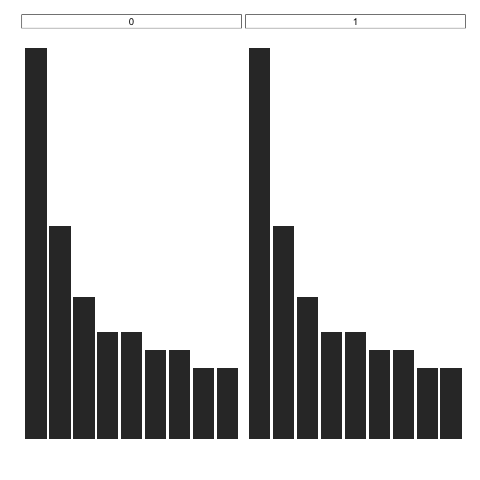

In [58]:
%%R
g <- ggplot(newdf, aes(x=Noun))
g + geom_histogram() + theme_classic() + labs(x="") + 
    facet_grid(~Condition)+theme(axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      axis.title.x=element_blank(),
      axis.title.y=element_blank(),
      legend.position="none")

In [61]:
%%R
ggsave("0156-rating.png", width = 12, height = 4 )

In [33]:
%%R

head(newdf)

Error in head(newdf) : object 'newdf' not found


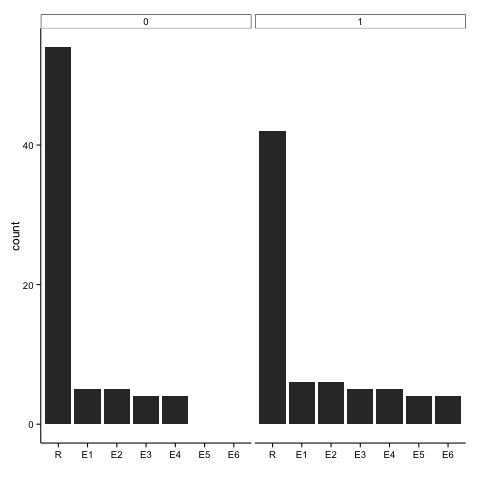

In [62]:
%%R

nnewdf <- subset(newdf, Inflect != 'null')
nnewdf$Inflect <- factor(nnewdf$Inflect, levels = c("R", "E1", "E2", "E3", "E4", "E5", "E6"))
head(newdf)

g <- ggplot(nnewdf, aes(x=Inflect))
g + geom_histogram() + theme_classic() + labs(x="")+facet_grid(~ Condition)


In [35]:
%%R
condition_map <- ddply(dp, .(condition, uniqueid), summarize, NumSubs = length(unique(uniqueid)))
newdp <- merge(mdata, condition_map, on="uniqueid")
sum_data_prod = summarySE(newdp, measurevar="value", groupvars=c("condition","users_answer_cat"), na.rm=TRUE)
print(sum_data_prod)

             condition users_answer_cat N    value       sd       se       ci
1 5 Rule | 4 Exception               ka 8 56.25000 40.02727 14.15178 33.46364
2 5 Rule | 4 Exception           non-ka 8 13.54167 24.37207  8.61683 20.37556
3 5 Rule | 4 Exception            other 8 30.20833 38.30162 13.54167 32.02095
4 3 Rule | 6 Exception               ka 7 53.57143 30.75333 11.62367 28.44208
5 3 Rule | 6 Exception           non-ka 7 30.95238 27.09478 10.24086 25.05849
6 3 Rule | 6 Exception            other 7 15.47619 30.59161 11.56254 28.29252


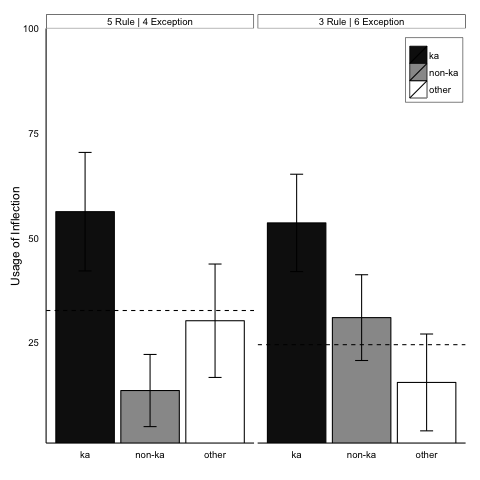

In [36]:
%%R
sum_data_prod$condition <- factor(sum_data_prod$condition)
dummy <- data.frame(condition = c("5 Rule | 4 Exception", "3 Rule | 6 Exception"), Z = c(32.65, 24.49))

# Error bars represent standard error of the mean
g = ggplot(sum_data_prod, aes(x=users_answer_cat, y=value, fill=users_answer_cat), colour="black") + 
    geom_bar(position=position_dodge(), stat="identity", colour="black") +theme_classic()+ coord_cartesian(ylim=c(1.0,100.0)) + 
    facet_grid(~ condition) +geom_hline(data = dummy, aes(yintercept = Z), linetype="dashed")+ scale_fill_manual(values=c("#111111", "#999999", "000000"))+
    ylab("Usage of Inflection")+xlab("")

g = g + theme(axis.ticks=element_blank(), legend.title=element_blank(), legend.background = element_rect(colour="#111111",size=0.25), legend.position=c(0.925,0.90))

g +geom_errorbar(aes(ymin=value-se, ymax=value+se), width=.2, position=position_dodge(.9))

In [37]:
%%R
ggsave("0153-production.png")

Saving 6.67 x 6.67 in image


In [38]:
%%R
subo <- subset(dp, users_answer_cat != 'other')
thistab <- table(subo$uniqueid, subo$users_answer_cat, subo$noun)
with(subo, table(uniqueid, users_answer_cat)) -> gen.adm.table
thisdp <- prop.table(gen.adm.table, 1)*100
#print(gen.adm.table)
mdata <- melt(thisdp, id="uniqueid")
#print(mdata)


cdata <- cast(mdata, uniqueid~users_answer_cat)
print(cdata)

                                        uniqueid        ka    non-ka other
1  A13VIJ7G997ZCY:3R2UR8A0IAHW3GFC676TUK7M7PKXOE  36.36364 63.636364     0
2  A18LPAFMK1B06K:3NJM2BJS4W7QLIGIUBNL57R2GCSCP8 100.00000  0.000000     0
3  A1M03U3W99BGZ4:36W0OB37HWFBGUT43CZO7WQW334HZ7  50.00000 50.000000     0
4  A1P3Z24Y6GRNVA:3WEV0KO0OMTX322OMOMQKIEVOWBSD4 100.00000  0.000000     0
5  A1VNYP58BTF4HX:3TXWC2NHNZRL0CP7A8HOYMV5XBWS9N 100.00000  0.000000     0
6  A280RC0S51YKFT:3VBEN272MK00FMCFOENYQ3HS1ORSGE  11.11111 88.888889     0
7  A2L772YDACSPHF:34J10VATJFZ2YX3XMYYWGFF7YDZIQ8        NA        NA    NA
8  A2R40R4O6G0YBY:3HYA4D452RK1WNZMJF2AH04C2FT2FN 100.00000  0.000000     0
9  A2VD133723IZR8:36NEMU28XFETEDPAJMVU0X4A3NZMWV  58.33333 41.666667     0
10 A36SM7QM8OK3H6:37M28K1J0QE66SGMFKMA2GF27A2AJ5  50.00000 50.000000     0
11 A37I58C4258IPX:3PZDLQMM0TMUTBFCSDC99UJ95212CC 100.00000  0.000000     0
12 A3BFXVLAJK3SH9:3IO1LGZLK9YGZ980Y387XL42VGI86T  41.66667 58.333333     0
13 A3URNV625JS985:3C5W7UE

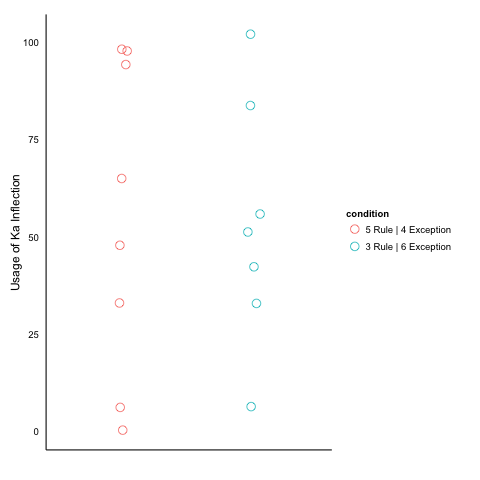

In [39]:
%%R
newdp2<- subset(newdp, users_answer_cat == 'ka')
sum_data_prod2 = summarySE(newdp2, measurevar="value", groupvars=c("condition","uniqueid","users_answer_cat"), na.rm=TRUE)
#dummy <- data.frame(condition = c("5 Rule | 4 Exception", "3 Rule | 6 Exception"), Z = c(75.0, 58.3))

# Error bars represent standard error of the mean
p = ggplot(sum_data_prod2, aes(x=condition, y=value)) + geom_point(shape = 1, position = position_jitter(width = .05), size=4, aes(color = condition)) 

# +theme_classic()+ coord_cartesian(ylim=c(1.0,100.0)) + 
#     facet_grid(~ condition) + 
#     ylab("Usage of Inflection")+xlab("")
p +theme_classic()+ theme(axis.ticks=element_blank(), axis.text.x = element_blank())+xlab("")+ylab("Usage of Ka Inflection")



In [40]:
%%R
condition_map <- ddply(dp, .(condition, uniqueid), summarize, NumSubs = length(unique(uniqueid)))
newdp <- merge(cdata, condition_map, on="uniqueid")
newdp <- rename(newdp, c("non-ka"="non.ka"))

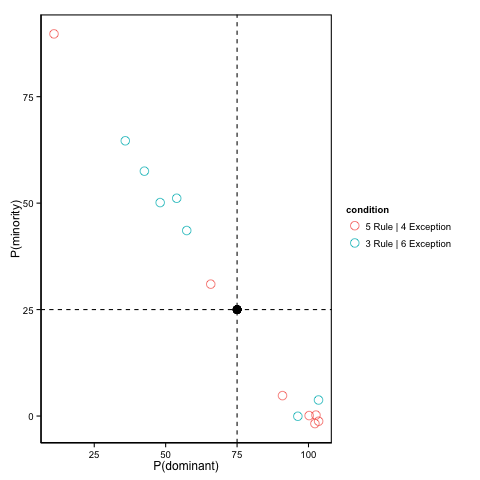

In [41]:
%%R
g = ggplot(newdp, aes(x=ka, y=non.ka)) + geom_point(shape = 1, position = position_jitter(width = 4, height=4), size=4, aes(color = condition)) + theme_classic()+ylab("P(minority)")+xlab("P(dominant)")
g = g + geom_hline(aes(yintercept=25.0), linetype="dashed") + geom_vline(aes(xintercept=75.0), linetype="dashed")+ geom_point(aes(y=25, x=75), color="black", size=4) 
g + theme(panel.border = element_rect(fill=NA, linetype="solid", size=1))

In [42]:
%%R
sum_data_rating2 = summarySE(dr, measurevar="user_input", groupvars=c("uniqueid","type", "detcat"), na.rm=TRUE)
print(sum_data_rating2)

                                        uniqueid      type detcat N user_input
1  A13VIJ7G997ZCY:3R2UR8A0IAHW3GFC676TUK7M7PKXOE   correct     ka 4   3.000000
2  A13VIJ7G997ZCY:3R2UR8A0IAHW3GFC676TUK7M7PKXOE   correct non-ka 4   3.500000
3  A13VIJ7G997ZCY:3R2UR8A0IAHW3GFC676TUK7M7PKXOE incorrect     ka 2   3.500000
4  A13VIJ7G997ZCY:3R2UR8A0IAHW3GFC676TUK7M7PKXOE incorrect non-ka 6   4.000000
5  A18LPAFMK1B06K:3NJM2BJS4W7QLIGIUBNL57R2GCSCP8   correct     ka 4   2.000000
6  A18LPAFMK1B06K:3NJM2BJS4W7QLIGIUBNL57R2GCSCP8   correct non-ka 4   1.000000
7  A18LPAFMK1B06K:3NJM2BJS4W7QLIGIUBNL57R2GCSCP8 incorrect     ka 2   5.000000
8  A18LPAFMK1B06K:3NJM2BJS4W7QLIGIUBNL57R2GCSCP8 incorrect non-ka 6   3.000000
9  A1M03U3W99BGZ4:36W0OB37HWFBGUT43CZO7WQW334HZ7   correct     ka 4   5.000000
10 A1M03U3W99BGZ4:36W0OB37HWFBGUT43CZO7WQW334HZ7   correct non-ka 3   4.333333
11 A1M03U3W99BGZ4:36W0OB37HWFBGUT43CZO7WQW334HZ7 incorrect     ka 2   5.000000
12 A1M03U3W99BGZ4:36W0OB37HWFBGUT43CZO7WQW334HZ7 inc

In [43]:
%%R
print(newdp2)

                                        uniqueid users_answer_cat      value
1  A13VIJ7G997ZCY:3R2UR8A0IAHW3GFC676TUK7M7PKXOE               ka  33.333333
4  A18LPAFMK1B06K:3NJM2BJS4W7QLIGIUBNL57R2GCSCP8               ka 100.000000
8  A1M03U3W99BGZ4:36W0OB37HWFBGUT43CZO7WQW334HZ7               ka   8.333333
10 A1P3Z24Y6GRNVA:3WEV0KO0OMTX322OMOMQKIEVOWBSD4               ka  50.000000
14 A1VNYP58BTF4HX:3TXWC2NHNZRL0CP7A8HOYMV5XBWS9N               ka  33.333333
18 A280RC0S51YKFT:3VBEN272MK00FMCFOENYQ3HS1ORSGE               ka   8.333333
21 A2L772YDACSPHF:34J10VATJFZ2YX3XMYYWGFF7YDZIQ8               ka   0.000000
22 A2R40R4O6G0YBY:3HYA4D452RK1WNZMJF2AH04C2FT2FN               ka 100.000000
26 A2VD133723IZR8:36NEMU28XFETEDPAJMVU0X4A3NZMWV               ka  58.333333
30 A36SM7QM8OK3H6:37M28K1J0QE66SGMFKMA2GF27A2AJ5               ka  50.000000
33 A37I58C4258IPX:3PZDLQMM0TMUTBFCSDC99UJ95212CC               ka 100.000000
34 A3BFXVLAJK3SH9:3IO1LGZLK9YGZ980Y387XL42VGI86T               ka  41.666667